In [1]:
import sys
import regex as re
import numpy as np
import io
import matplotlib.pyplot as plt
import pandas as pd
import math
import h5py
import time
import os
import datetime
import pickle
import seaborn

LOCAL = True
BASE_DIR = '../'

if not LOCAL:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_DIR = '/content/drive/My Drive/Colab Notebooks/thesis/'

sys.path.append(BASE_DIR + 'lib')
sys.path.append(BASE_DIR + 'config')
from preprocessing import process_sakt, save_h5, transpose_list, process_one_feature, select_from_rows, progressBar
import dataset_parameters as params

THREE_DAYS = 259200

DATASET = 'akribian'
# DATASET = 'assistments_2009'
# DATASET = 'assistments_2012'
# DATASET = 'junyi_academy'
# DATASET = 'ednet'

INPUT_DIR = BASE_DIR + 'data/' + DATASET + '/raw/'
OUTPUT_DIR = BASE_DIR + 'data/' + DATASET + '/processed/'
# IN_FILE_NAME = 'rawdata.csv'
# IN_FILE_NAME = 'sorted.csv'
IN_FILE_NAME = 'transformed.csv'
FILE_NAME = 'relation_matrix.npy'

TIME_STEPS = params.time_steps_dict[DATASET]
VALIDATION_RATIO = 0.2
TEST_RATIO = 0.05
SPLIT_SECTIONS = 5

ROWS_PER_READ = 10000000
SHUFFLE = False

STRIDE = params.stride_dict[DATASET]
CALCULATE_NUM_EXERCISES = False
THETA = 0.1

## Load the data

In [2]:
number_of_rows = -1
number_of_exercises = params.exercise_dict[DATASET]
number_of_ids = params.exercise_id_dict[DATASET]
time_scale = params.time_scale_dict[DATASET]
with open(OUTPUT_DIR + "category_to_idx.pkl", "rb") as f:
    category_to_index = pickle.load(f)
with open(OUTPUT_DIR + "id_to_idx.pkl", "rb") as f:
    id_to_index = pickle.load(f)

In [3]:
print(category_to_index)

{'PADDING': 0, 'M04T11: GT - Missing Number 336 Activity Intro': 1, 'M04T10: Fluency C - Missing Number (FF 055)': 2, 'M02T01: AI - Sameness': 3, 'M04T10: Fluency B - Missing Number (FF 145)': 4, 'M04T06: Fluency C - Math Facts (x-1, x-y=1 combined)': 5, 'M04T08: Fluency B - Math Facts (x-2)': 6, 'M04T09: Introduction to Fact Family 4': 7, 'M02T03: Fluency - See nums/Select equal or not (A)': 8, 'M04T08: Missing Sign Activity Intro': 9, 'M04T10: Fluency B - Missing Number (FF 055)': 10, 'M04T09: Introduction to FF 134 Activity Intro': 11, 'M04T03: Missing Number (FF 044) - Fluency C': 12, 'M04T11: Missing Number (combined FF 6) GT Activity Intro': 13, 'M04T10: Introduction to FF 145 Activity Intro': 14, 'M02T01: Drag and Drop Speed Assessment 30s Day 2': 15, 'M04T06: Fluency C - Math Facts (all +/- 1 combined)': 16, 'M04T11: Fluency A - Missing Number (FF 336)': 17, 'M04T07: GT +/-0 & x-x combined': 18, 'M04T10: Fluency A - Missing Number (FF 235)': 19, 'M04T09: Introduction to FF 044 

In [4]:
# contingency table to be later used for calculating relation matrix
contingency_table = np.zeros((number_of_ids, number_of_ids, 4))
def update_contingency_matrix(student_seq):
    correctness = student_seq[1]
    ex_id = student_seq[2]
    for idx_i in range(len(correctness)):
        exercise_i = ex_id[idx_i]
        answer_i = correctness[idx_i]
        for idx_j in range(idx_i):
            exercise_j = ex_id[idx_j]
            answer_j = correctness[idx_j]
            # Binary indexing for the third dimension of contingency table
            index_z = int(2 * answer_j + answer_i)
            contingency_table[exercise_i, exercise_j, index_z] += 1

In [5]:
read_index = 0

columns = params.columns_dict['generic']
group_column = columns[0]
encoding = params.encodings_dict[DATASET]

# Remember that DataFrames are immutable
while(True):  
  # Print progress
  if number_of_rows > 0:
    print("Reading %i/%i..." % (math.ceil(read_index/ROWS_PER_READ) + 1, math.ceil(number_of_rows/ROWS_PER_READ) + 1))
  else:  
    print("Reading %i..." % (math.ceil(read_index/ROWS_PER_READ) + 1))

  start_time = time.time()

  # Read rows
  data = pd.read_csv(INPUT_DIR + IN_FILE_NAME, encoding = encoding, nrows=ROWS_PER_READ, skiprows=[i for i in range(1, read_index)], usecols=columns)

  print("Data read in %.2f seconds" % (time.time() - start_time))

  data = data[columns]

  # If all the rows are read, break out of the loop
  if len(data) == 0:
      print("Out of usable data, breaking...")
      break
  
  # Group rows
  sys.stdout.write("Grouping data... ")
  series = data.groupby([group_column]).agg({lambda x: list(x)})
  series_np = series.to_numpy()
  print("Done.")

  # series_np is an array of array of lists, each array of lists is a student's 
  # entire history, indices are 0:exercise category, 1:correctness, 2:exercise id
  # for example series_np[x,1] is student x's correctness values
  print("Generating contingency matrix...")
  for idx, student in enumerate(series_np):
      progressBar(idx, len(series_np))
      update_contingency_matrix(student)
  progressBar(1, 1)

  # Delete unnecessary variables to free up ram
  del data
  del series
  del series_np
  read_index += ROWS_PER_READ

  # test brake, uncomment to only use first million rows
  # break

print("Contingecy matrix done!")

Reading 1...
Data read in 0.08 seconds
Grouping data... Done.
Generating contingency matrix...
🐌🏠
Done!
Reading 2...
Data read in 1.24 seconds
Out of usable data, breaking...
Contingecy matrix done!


In [6]:
# Relation matrix consists of phi coefficients between exercises
# First dimension is i, second dimension is j
# for n-dimension: n[0] is n00, n[1] is n01, n[2] is n10, n[3] is n11
print("Generating relation matrix...")
relation_matrix = np.zeros((number_of_ids, number_of_ids))
for idx_i in range(number_of_ids):
  progressBar(idx_i, number_of_ids)
  for idx_j in range(number_of_ids):
    n = contingency_table[idx_i, idx_j]
    numerator = n[3] * n[0] - n[1] * n[2]
    denominator = math.sqrt((n[0] + n[1]) * (n[2] + n[3]) * (n[0] + n[2]) * (n[1] + n[3]))
    if denominator == 0:
      continue
    relation_matrix[idx_i, idx_j] = numerator/denominator
progressBar(1,1)

Generating relation matrix...
🐌🏠
Done!


In [7]:
start_time = time.time()
print("Saving relation matrix...")
np.save(OUTPUT_DIR + FILE_NAME, relation_matrix)
print("Done!")
print("Wrote %.2f MB in %.2f seconds" % (relation_matrix.size * relation_matrix.itemsize / 1024. / 1024., time.time() - start_time))

Saving relation matrix...
Done!
Wrote 4.73 mb in 0.02 seconds


<AxesSubplot:>

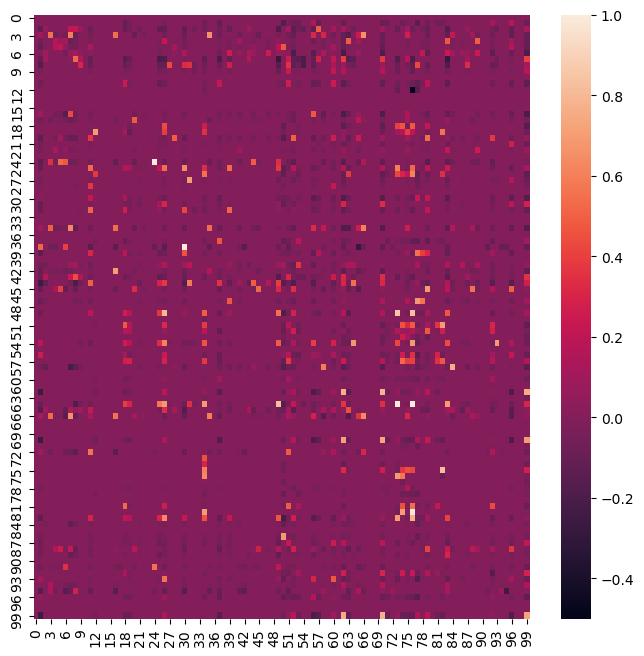

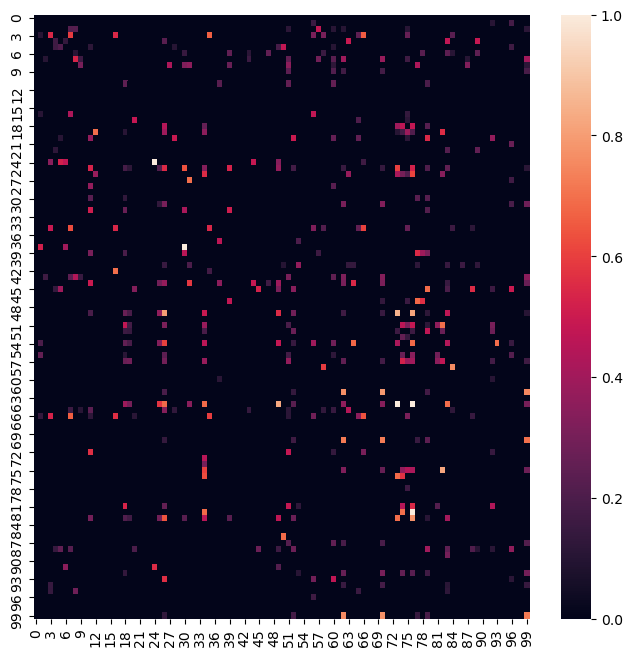

In [8]:
# Show the figure
plt.figure(1, figsize=(8,8), dpi=100)
seaborn.heatmap(relation_matrix[:100,:100])

# Threshold the relations matrix with theta
relation_matrix[relation_matrix < THETA] = 0.
plt.figure(2, figsize=(8,8), dpi=100)
seaborn.heatmap(relation_matrix[:100,:100])